In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import statsmodels as sm
import statsmodels.api as sma

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    funcdir    = op.join(wd, 'analysis', 'tools')
    sys.path.insert(0, funcdir)
os.chdir(wd)
# sys.path.insert(0, eyefuncdir)
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))

#import eyefuncs_v2 as eyes
from funcs import getSubjectInfo, clusterperm_test

eyedir = op.join(wd, 'data', 'eyes')
bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26]) #eeg ppts
# subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26]) # eyetracking ppts
nsubs = subs.size
#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy')), 2)

b_prec = np.zeros(shape = [nsubs, 2, modeltimes.size]) * np.nan
b_amp = b_prec.copy()
t_prec, t_amp = b_prec.copy(), b_prec.copy()

In [2]:
subcount = -1
print('looping over participants and modelling')
for sub in subs:
    subcount += 1 
    # print(f'- - - working on ppt {sub} - - -')
    #load in the parameter fits for this participant
    binstep, binwidth = 4, 22
    smooth_alphas, smooth_sigma = True, 3
    
    #read in modelled tuning curve parameters
    alpha = np.load(op.join(wd, 'data', 'tuningcurves', 'parameter_fits', 'twostage_alphaminmaxfit_b1desmatminmax',
            f's{sub}_ParamFits_precision_binstep{binstep}_binwidth{binwidth}_smoothedprec.npy'))
    ampglm = np.load(op.join(wd, 'data', 'tuningcurves', 'parameter_fits', 'twostage_alphaminmaxfit_b1desmatminmax',
        f's{sub}_ParamFits_amplitude_binstep{binstep}_binwidth{binwidth}_smoothedprec_glmfit.npy'))
    
    #note here precision is modelled in the same way, but amplitude is modelled with a constrained alpha (min 0.001), and minmax-scaled design matrix for the glmfit. optimised fit doesnt have to scale the design matrix
    tcbdata = pd.read_csv(op.join(wd, 'data', 'tuningcurves', f's{sub}_TuningCurve_metadata.csv')) #read in associated behavioural data
    #metadata doesnt have the behavioural preproc output
    tcbdata = tcbdata.assign(trlid = np.where(tcbdata.session.eq('a'), tcbdata.trialnum, tcbdata.trialnum+256))
    
    #so lets grab the file that does
    isub = dict(loc = loc, id = sub); param = getSubjectInfo(isub)
    bdata = pd.read_csv(op.join(param['path'], 'datafiles', f's{sub:02d}', f'wmConfidence_S{sub:02d}_gathered_preprocessed.csv')) #has full behavioural preproc done
    bdata = bdata.assign(trlid = np.where(bdata.session.eq('a'), bdata.trialnum, bdata.trialnum+256)) #get trialnumber
    bdata = bdata.query('trlid in @tcbdata.trlid') #take just the trials used in the tuning curve decomposition

    #drop trials with slow RTs (more than 2.5sds from the ppt mean)
    keeptrls = bdata.DTcheck.eq(0).to_numpy()
    alpha  = alpha[:,keeptrls]
    ampglm = ampglm[:,keeptrls]
    bdata = bdata.query('DTcheck==0') #discard outlier trials based on RT

    
    [nitems, ntrials, ntimes] = alpha.shape #get some feature dimensions
    
    #get things
    pitem = bdata.pside.to_numpy() #vector describing which side the subsequently probed item was on. 0 = left, 1 = right item
    error = bdata.absrdif.to_numpy() #absolute angular error on a given trial
    rt    = bdata.DT.to_numpy() #decision time - time taken to move the mouse to start reporting the orientation
    
    er_z = sp.stats.zscore(error, ddof = 0) #zscore error
    logerr = np.log(np.where(error==0, 0.1, error)) #take log of error to make distribution normal. given 0 degree error trials similarly low value that doesnt cause issues with log transform
    logrt = np.log(rt) #log transform reaction times (note that we aren't cutting out any trials yet)
    logrt_z = sp.stats.zscore(logrt, ddof=0) #zscore RTs
    
    precision = np.nanmean(alpha, axis=0) #average tuning curve precision across items in the array
    amplitude = np.nanmean(ampglm, axis=0)[:,0] #take just the parameter estimate for amplitude fit, average across items in the array
    
    #get precision and amplitude of the item that was actually probed - lets us test if precision/amplitude of the representation of the item that was actually reported is relevant for behaviour
    itemprec = np.zeros(shape = [ntrials, ntimes]) * np.nan
    itemamp = np.zeros(shape = [ntrials, ntimes]) * np.nan
    for itrl in range(ntrials):
        ipside = pitem[itrl]
        itemprec[itrl] = alpha[ipside, itrl]
        itemamp[itrl]  = ampglm[ipside, itrl, 0] #keep just the parameter estimate

    #empty vectors to store data
    betas_prec = np.zeros(shape = [2, ntimes]) * np.nan
    tvals_prec = np.zeros(shape = [2, ntimes]) * np.nan
    betas_amp = np.zeros(shape = [2, ntimes]) * np.nan
    tvals_amp = np.zeros(shape = [2, ntimes]) * np.nan

    #fitting the same design matrix at each time point, so just make it once
    dm = np.array([np.ones(ntrials), logrt]).T
    # dm = np.array([np.ones(ntrials), logrt_z]).T
    dm = pd.DataFrame(dm, columns = ['constant', 'logRT'])
    
    for tp in range(modeltimes.size): #loop over time points
        # iprec, iamp = precision[:,tp], amplitude[:, tp]
        # iprec, iamp = sp.stats.zscore(iprec, ddof=0), sp.stats.zscore(iamp, ddof=0)

        #get item specific tuning curve parameter estimates
        iprec, iamp = itemprec[:,tp], itemamp[:,tp]
        iprec, iamp = sp.stats.zscore(iprec, ddof=0), sp.stats.zscore(iamp, ddof=0)

        #model precision
        gl1 = sma.GLM(endog = iprec, exog = dm, family = sma.families.Gaussian())
        gl1fit = gl1.fit()

        #model amplitude
        gl2 = sma.GLM(endog = iamp, exog = dm, family = sma.families.Gaussian())
        gl2fit = gl2.fit()
        
        #store parameter estimates
        betas_prec[:, tp] = gl1fit.params.to_numpy()
        betas_amp[:,tp]   = gl2fit.params.to_numpy()

        #store individual ppt t-values for effects
        tvals_prec[:,tp] = gl1fit.tvalues.to_numpy()
        tvals_amp[:,tp]  = gl2fit.tvalues.to_numpy()
    
    b_prec[subcount] = betas_prec
    b_amp[subcount]  = betas_amp
    t_prec[subcount] = tvals_prec
    t_amp[subcount]  = tvals_amp
print('done fitting on all participants')

looping over participants and modelling
done fitting on all participants


stat_fun(H1): min=-1.7470912797152025 max=1.1273431782578365
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 1048574/1048574 [00:34<00:00, 30553.13it/s]


cluster p-values for precision regressor: [0.40348473]
stat_fun(H1): min=-2.774781594621631 max=1.3070143046769196
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 1048574/1048574 [00:41<00:00, 25522.38it/s]


cluster p-values for amplitude regressor: [0.12276089 0.20623799 0.57127149]
stat_fun(H1): min=-1.6884310466861427 max=1.104253126746954
Running initial clustering …
Found 0 clusters
cluster p-values for precision regressor: []
stat_fun(H1): min=-2.4443299887256664 max=1.3698750457790614
Running initial clustering …
Found 3 clusters


C:\Users/sammirc/Desktop/postdoc/tuningcurves\analysis\tools\funcs.py:304: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_1samp_test(data_twin, out_type=out_type, n_permutations = n_permutations, tail = tail, threshold = threshold, n_jobs = n_jobs)
100%|██████████| Permuting : 1048574/1048574 [00:40<00:00, 25628.60it/s]


cluster p-values for amplitude regressor: [0.22132132 0.21834204 0.56911809]


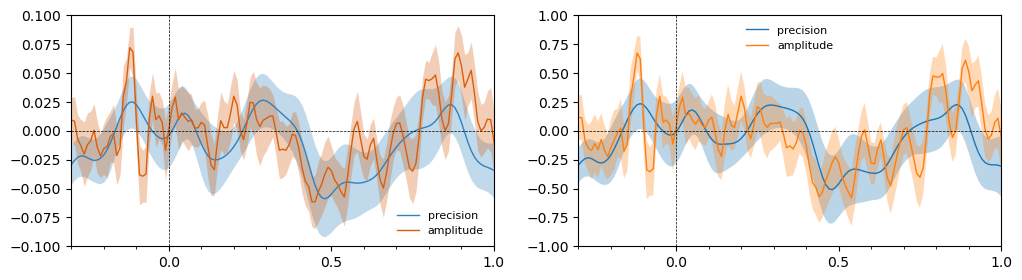

In [4]:
#params for cluster forming
sigalpha = 0.05
df = nsubs-1
t_thresh = sp.stats.t.ppf(1-sigalpha, df = df)
tmin, tmax = 0, 0.75 #time-window for cluster permutation testing

gm_bp = b_prec.mean(0); sem_bp = sp.stats.sem(b_prec, axis=0, ddof=0, nan_policy = 'omit')
gm_ba = b_amp.mean(0);  sem_ba = sp.stats.sem(b_amp, axis=0, ddof=0, nan_policy = 'omit')
gm_tp = t_prec.mean(0); sem_tp = sp.stats.sem(t_prec, axis=0, ddof=0, nan_policy = 'omit')
gm_ta = t_amp.mean(0);  sem_ta = sp.stats.sem(t_amp, axis=0, ddof=0, nan_policy = 'omit')

cols = ['#3182bd', '#d95f0e']

fig = plt.figure(figsize = [12, 3])
ax = fig.add_subplot(121)
ax.plot(modeltimes, gm_bp[1], lw = 1, label = 'precision', color = cols[0])
ax.fill_between(modeltimes, np.add(gm_bp[1], sem_bp[1]), np.subtract(gm_bp[1], sem_bp[1]),
                lw = 0, edgecolor = None, alpha = 0.3, color = cols[0])
ax.plot(modeltimes, gm_ba[1], lw = 1, label = 'amplitude', color = cols[1])
ax.fill_between(modeltimes, np.add(gm_ba[1], sem_ba[1]), np.subtract(gm_ba[1], sem_ba[1]),
                lw = 0, edgecolor = None, alpha = 0.3, color = cols[1])
ax.axhline(0, ls = 'dashed', lw = 0.5, color = 'k')
ax.axvline(0, ls = 'dashed', lw = 0.5, color = 'k')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax.set_xlim([-0.3, 1])

#cluster stats?
labs = ['precision', 'amplitude']
for iparam in range(2):
    icol = cols[iparam]
    if iparam == 0:
        ilabs = np.array(['mean', 'precision'])
        ih = -0.04
        idat = b_prec.copy() #take precision param estimate
    elif iparam == 1:
        ilabs = np.array(['mean', 'amplitude'])
        ih = -0.05
        idat = b_amp.copy() #take amplitude parameter estimate

    tv, clu, clupv, _ = clusterperm_test(data = idat, labels = ilabs, of_interest = labs[iparam], times = modeltimes,
                                         tmin = tmin, tmax = tmax, out_type='indices', n_permutations='all',
                                         threshold = -t_thresh, tail=-1, n_jobs=4) #one-tailed test
    clu = [x[0] for x in clu]
    print(f'cluster p-values for {labs[iparam]} regressor: {clupv}')
    times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
    nclus = len(clu)
    for icluster in range(nclus):
        mask = clu[icluster]
        if clupv[icluster] <= sigalpha:
            itmin = times_twin[mask[0]]
            itmax = times_twin[mask[-1]]
            ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)
ax.set_ylim([-0.1, 0.1])
ax.legend(frameon=False, fontsize = 8)        

ax = fig.add_subplot(122)
ax.plot(modeltimes, gm_tp[1], lw = 1, label = 'precision')
ax.fill_between(modeltimes, np.add(gm_tp[1], sem_tp[1]), np.subtract(gm_tp[1], sem_tp[1]),
                lw = 0, edgecolor = None, alpha = 0.3)
ax.plot(modeltimes, gm_ta[1], lw = 1, label = 'amplitude')
ax.fill_between(modeltimes, np.add(gm_ta[1], sem_ta[1]), np.subtract(gm_ta[1], sem_ta[1]),
                lw = 0, edgecolor = None, alpha = 0.3)
ax.axhline(0, ls = 'dashed', lw = 0.5, color = 'k')
ax.axvline(0, ls = 'dashed', lw = 0.5, color = 'k')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax.set_xlim([-0.3, 1])
ax.set_ylim([-1, 1])

#cluster stats?
labs = ['precision', 'amplitude']
for iparam in range(2):
    icol = cols[iparam]
    if iparam == 0:
        ilabs = np.array(['mean', 'precision'])
        ih = -0.8
        idat = t_prec.copy() #take precision param estimate
    elif iparam == 1:
        ilabs = np.array(['mean', 'amplitude'])
        ih = -0.82
        idat = t_amp.copy() #take amplitude parameter estimate

    tv, clu, clupv, _ = clusterperm_test(data = idat, labels = ilabs, of_interest = labs[iparam], times = modeltimes,
                                         tmin = tmin, tmax = tmax, out_type='indices', n_permutations='all',
                                         threshold = -t_thresh, tail=-1, n_jobs=4) #one-tailed test
    clu = [x[0] for x in clu]
    print(f'cluster p-values for {labs[iparam]} regressor: {clupv}')
    times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
    nclus = len(clu)
    for icluster in range(nclus):
        mask = clu[icluster]
        if clupv[icluster] <= sigalpha:
            itmin = times_twin[mask[0]]
            itmax = times_twin[mask[-1]]
            ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)
ax.legend(frameon=False, fontsize = 8)        